In [1]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
Train_data = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('data/used_car_testB_20200421.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [4]:
## 通过.head() 简要浏览读取数据的形式
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [6]:
## 通过 .columns 查看列名
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [7]:
TestA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            50000 non-null  int64  
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           48496 non-null  float64
 6   fuelType           47076 non-null  float64
 7   gearbox            48032 non-null  float64
 8   power              50000 non-null  int64  
 9   kilometer          50000 non-null  float64
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  int64  
 13  offerType          50000 non-null  int64  
 14  creatDate          50000 non-null  int64  
 15  v_0                50000 non-null  float64
 16  v_1                500

In [8]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [9]:
TestA_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


In [10]:
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [11]:
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['notRepairedDamage'], dtype='object')


In [12]:
## 选择特征列
feature_cols = [col for col in numerical_cols if col not in ['SaleID','name','regDate','creatDate','price','model','brand','regionCode','seller']]
feature_cols = [col for col in feature_cols if 'Type' not in col]

## 提前特征列，标签列构造训练样本和测试样本
X_data = Train_data[feature_cols]
Y_data = Train_data['price']

X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
print('X test shape:',X_test.shape)

X train shape: (150000, 18)
X test shape: (50000, 18)


In [13]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [14]:
print('Sta of label:')
Sta_inf(Y_data)

Sta of label:
_min 11
_max: 99999
_mean 5923.327333333334
_ptp 99988
_std 7501.973469876635
_var 56279605.942732885


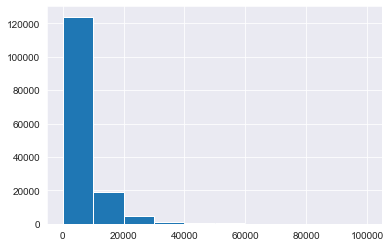

In [15]:
## 绘制标签的统计图，查看标签分布
plt.hist(Y_data)
plt.show()
plt.close()

In [16]:
X_data = X_data.fillna(-1)
X_test = X_test.fillna(-1)

In [17]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

Train mae: 613.1617850640108
Val mae 708.5301055502574


In [18]:
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [19]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [20]:
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Train lgb...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4097
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 18
[LightGBM] [Info] Start training from score 5918.314310
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4097
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 18
[LightGBM] [Info] Start training from score 5919.850952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4097
[LightGBM] [Info] Number of data points in the train set: 84000, number of used features: 18
[LightGB

In [21]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Train xgb...
MAE of val with xgb: 705.8140263239754
Predict xgb...
Sta of Predict xgb:
_min -542.2186
_max: 91425.125
_mean 5909.7793
_ptp 91967.34
_std 7352.523
_var 54059590.0


In [23]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 683.5215734557753


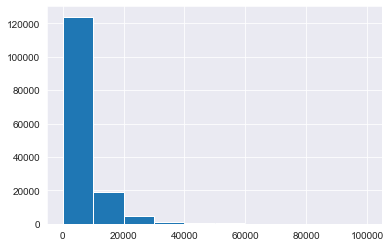

In [24]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

In [25]:
sub = pd.DataFrame()
sub['SaleID'] = TestA_data.SaleID
sub['price'] = sub_Weighted
sub.to_csv('./sub_Weighted.csv',index=False)

In [26]:
sub.head()

,SaleID,price
0,200000,1177.741520
1,200001,1868.358168
2,200002,8525.105698
3,200003,1329.322068
4,200004,2052.414618
